# I - CREATE & PREPROCESS DATASET

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn import decomposition

In [4]:
def load_data(file : str) -> pd.DataFrame:   
  """ Load the dataset. """
  na_val = ["n/a", "na", "?", "NaN"]
  df = pd.read_csv(file, na_values = na_val)
  return df

In [13]:
def replace_na_values(df : pd.DataFrame) -> pd.DataFrame:
  """ Return the data with the na values filled by the mean of the column. """
  n = len(df.columns)
  for i in range(n):
    index = 0
    while type(df[df.columns[i]][index]) == float:
        index += 1
    if type(df[df.columns[i]][index]) != str:
        df[df.columns[i]] = df[df.columns[i]].fillna(df[df.columns[i]].mean())   
    else:
        df[df.columns[i]] = df[df.columns[i]].fillna(df[df.columns[i]].mode()[0])
  df = df.applymap(lambda x: x.replace("\t", "") if type(x) == str else x)
  df = df.applymap(lambda x: x.replace(" ", "") if type(x) == str else x)
  return df

In [14]:
def categoric_to_one_hot(df: pd.DataFrame) -> pd.DataFrame: 
  """ Transform categorical data to one hot encoded vectors. """
  a=0
  if df[df.columns[-1]].dtype != int:
    a=1
  n = len(df.columns)
  cols = [] #Categorical columns we will drop at the end
  for i in range(n):
    if df[df.columns[i]].dtype == str or df[df.columns[i]].dtype == object:
      cols.append(i)
      df[df.columns[i]] = pd.Categorical(df[df.columns[i]])
      new_cols = pd.get_dummies(df[df.columns[i]], prefix = list(df.columns)[i] )
      df = pd.concat([df, new_cols] , axis=1, sort=False)
  df.drop(df.columns[cols], axis=1, inplace=True)
  if a == 1:
    df = df.drop(df.columns[-1],axis=1)
  return df


In [15]:
def preprocess_data(file : str) -> pd.DataFrame: 
  """ Preprocess the data. """
  return replace_na_values(load_data(file))

In [16]:
def create_datasets(db):    
    data = preprocess_data(db)
    X = pd.DataFrame(data.drop(data.columns[-1],axis=1))
    y = data[data.columns[-1]]
    return X, y

# II - TREE BASED MODEL

In [44]:
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [45]:
def train(X, y, classifier, kfold_num_splits=5):
   max = 0
   kf = KFold(n_splits=kfold_num_splits, shuffle=True)
   for train_index, test_index in kf.split(X):
      X_train = X.iloc[train_index,:]
      y_train = y[train_index]
      X_test  = X.iloc[test_index,:]
      y_test  = y[test_index]
      classifier.fit(X_train, y_train)
      predictions = classifier.predict(X_test)
      if max < metrics.accuracy_score(y_test, predictions):
         max = metrics.accuracy_score(y_test, predictions)
         X_train_f = X.iloc[train_index, :]
         y_train_f = y[train_index]
         X_test_f  = X.iloc[test_index, :]
         y_test_f  = y[test_index]
   predictions = classifier.predict(X_test_f)
   classifier.fit(X_train_f, y_train_f)
   #recall    = metrics.recall_score(y_test_f, predictions)
   #precision = metrics.precision_score(y_test_f, predictions)
   accuracy  = metrics.accuracy_score(y_test_f, predictions)
   return classifier, accuracy

In [46]:
def main(db, model='random_forest', criterion='gini', splitter='random', max_depth=5, num_splits=5):
    assert model in ['random_forest', 'decision_tree']
    if model == 'random_forest':
        classifier = RandomForestClassifier(criterion=criterion, max_depth=max_depth)
    else:
        classifier = tree.DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=5)
    X, y = create_datasets(db)
    return train(X, y, classifier, num_splits)


In [47]:
decision_tree, accuracy = main('medical_data3.csv', model='decision_tree')

In [57]:
db = preprocess_data('medical_data3.csv')

In [59]:
db

,Unnamed: 0,sexe,age,ercp,eus,prothese,duree,radiofrequence,sepsis,stenose,localisation_stenose,dilatation,longueur_stenose,progressivite_stenose,delais_ercp_spyglass,biopsies,n_biopsies,n_biopsies_histo,label
0,1,0,39.0,2,2.0,3.0,0.000000,0,0,1.0,2.000,0.000000,16.631579,0.782609,7.0,1,2.00,4.354839,6
1,2,0,62.0,2,0.0,1.0,6.000000,0,0,0.0,2.000,0.000000,16.631579,0.782609,4.0,1,5.75,4.354839,1
2,3,0,57.0,1,0.0,1.0,2.000000,0,0,1.0,1.000,1.000000,30.000000,0.782609,2.0,1,5.75,4.354839,3
3,4,1,80.0,2,1.0,0.0,0.000000,1,0,0.0,2.000,0.000000,0.000000,0.000000,52.0,1,5.75,4.354839,1
4,5,0,59.0,7,0.0,1.0,36.000000,0,1,0.0,1.475,1.000000,0.000000,0.782609,10.0,1,5.75,4.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,94,1,73.0,0,0.0,0.0,0.000000,0,0,1.0,2.000,1.000000,16.631579,0.782609,0.0,1,5.75,4.354839,4
94,95,1,69.0,1,0.0,0.0,10.195652,0,0,1.0,2.000,0.461538,16.631579,0.782609,11.5,1,5.75,2.000000,5
95,96,0,64.0,0,0.0,0.0,0.000000,0,1,1.0,2.000,1.000000,16.631579,0.782609,11.5,1,5.75,4.354839,1
96,97,1,73.0,1,0.0,1.0,0.000000,0,0,1.0,1.000,1.000000,50.000000,0.782609,11.5,1,5.75,7.000000,1


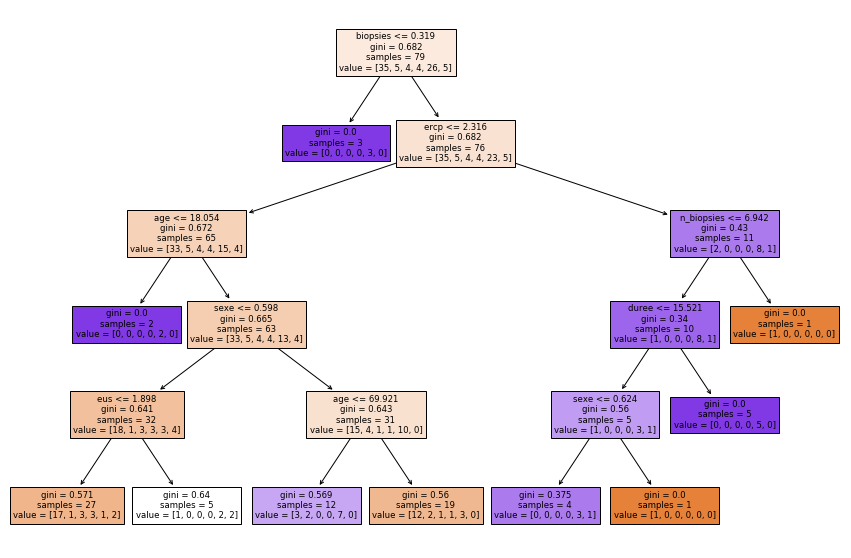

In [64]:
fig, ax = plt.subplots(figsize=(15,10))
tree.plot_tree(decision_tree, ax=ax, feature_names=db.columns.values.tolist(), filled=True)
plt.show()